# Metropolis-Hastings MCMC implementation (Python)

In [46]:
import numpy as np
from numpy import power as p 
from numpy import log
import matplotlib.pyplot as plt
import corner
from tqdm.notebook import tqdm

### Create mock data

The mock data we will create is drawn from the distribution $f$ which has PDF 
$$f(v| v_{esc},k) = \frac{k+1}{v_{esc}{}^{k+1}} (v_{esc} - v)^k \quad,\quad v\in[0,v_{esc}]$$

and CDF
$$ \text{CDF}_f(v) =  \left( 1 - \frac{v}{v_{esc}} \right)^{k+1} -1 \quad,\quad v\in[0,v_{esc}]$$

which has inverse 
$$  \text{CDF}_f{}^{-1}(y) = v_{esc}\left[ 1 - (1-y)^{\frac{1}{k+1}}  \right] \quad,\quad y\in[0,1] $$

We need the inverse CDF to generate samples from this distribution. Note also that the log likelihood is given by
$$ Log\left(\text{Likelihood} (D|v_{esc},k)  \right) = \sum_d Log(f(d|vesc,k)  ) $$

for a dataset D consisting of datapoints $d$, where each term is of the form
$$  Log(f(d|vesc,k)  ) =  Log(k+1) - (k+1)Log(v_{esc}) + k~Log(v_{esc} - v) $$

In [47]:
def powerlaw_PDF(v,x):
    vesc,k = x
    return ( (k+1)*p(vesc,-k-1) ) * p(vesc - v, k)

def powerlaw_inverse_CDF(y,x):
    vesc,k = x
    return vesc*( 1.0 - p( 1.0-y, 1.0/(k+1.0)) )

### Define helper functions

In [48]:
def generate_samples(N,inverse_CDF,x):
    # To sample from a distribution we perform inverse transform sampling, for which the inverse CDF is required
    return inverse_CDF(np.random.uniform(size=N),x)

### Sample from distribution to obtain data which we will fit via MCMC

We generate data with a specific escape velocity and $k$ to use in our parameter fit later

In [49]:
target_vesc = 550.0
target_k = 3.0
target_x = [target_vesc,target_k]
num_samples = 1000

target_data = generate_samples(num_samples,powerlaw_inverse_CDF,target_x)

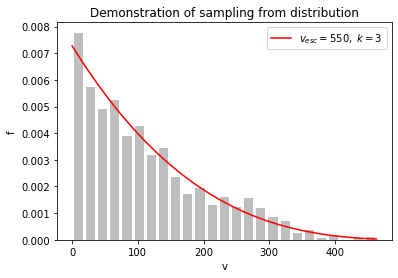

In [50]:
heights, bins, _ = plt.hist(target_data, bins=25, density=True, alpha=0.5,rwidth=0.75,color='C7')
plt.plot(bins, powerlaw_PDF(bins,target_x),color='red',label=r"$v_{esc}=550,~k=3$")
plt.title("Demonstration of sampling from distribution")
plt.xlabel("v")
plt.ylabel("f")
plt.legend()

# Define MCMC functions and parameters

In [51]:
def log_prior(x):
    vesc,k = x
    if 100 < vesc < 800 and 0.2 < k < 10 :
        return 0.0
    return -np.inf

def log_likelihood(x,data):
    vesc,k = x
    sum = 0
    
    for v in data:
        if v < vesc:
            sum += log(k+1) - (k+1)*log(vesc) + k*log(vesc - v)
        else:
            sum += -np.inf 

    return sum 

# Metropolis Hastings-specific functions
def step_model(x):
    return np.random.normal(x,[90,0.9],(2,))

def step_decision(likelihood_current,likelihood_new):
    if likelihood_new > likelihood_current:
        return True
    else:
        acceptance_threshhold = np.random.uniform()
        exp_likelihood_difference = np.exp(likelihood_new - likelihood_current)

        if exp_likelihood_difference > acceptance_threshhold:   
            # Take the step with a small probability proportional to how much "worse" the proposed step is. 
            # Very "bad" steps will have very small probability of being accepted
            return True
        else:
            return False

# Implement Metropolis-Hastings algorithm

In [52]:
def metropolis_hastings(data, iterations, x0, compute_likelihood, prior, step_model, step_decision):
    x = x0
    accepted_steps = []
    rejected_steps = []   
    
    for i in tqdm(range(iterations)): # tqdm is present for progress bar
        
        x_new =  step_model(x)    
        #print(x_new)

        current_likelihood = compute_likelihood(x,data)
        #print(current_likelihood)

        new_likelihood = compute_likelihood(x_new,data) 
        #print(new_likelihood)

        if step_decision( current_likelihood + prior(x) , new_likelihood + prior(x_new) ):            
            x = x_new
            accepted_steps.append(x_new)
        else:
            rejected_steps.append(x_new)            
                
    return np.array(accepted_steps), np.array(rejected_steps)

# Run MH algorithm

In [53]:
num_steps = 10000
burnin = 1
initial_guess = [600.0,4.0]

quantile_list = [0.16, 0.5, 0.84]

accepted, rejected = metropolis_hastings(target_data, num_steps, initial_guess, log_likelihood, log_prior, step_model, step_decision)

  0%|          | 0/10000 [00:00<?, ?it/s]

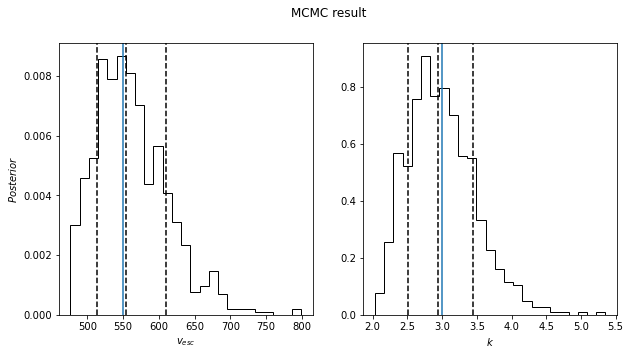

In [61]:
fig,axs=plt.subplots(ncols=2,figsize=(10,5))

fig.suptitle("MCMC result")

axs[0].hist(accepted[burnin:, 0], 25, color="k", histtype="step",density=True)
axs[0].set_xlabel(r"$v_{esc}$")
axs[0].set_ylabel(r"$Posterior$")
axs[0].axvline(x=target_vesc)
for quantile in quantile_list:
    axs[0].axvline( x=np.quantile(accepted[burnin:,0],quantile) , ls="--" , color='black' )

axs[1].hist(accepted[burnin:, 1], 25, color="k", histtype="step",density=True)
axs[1].set_xlabel(r"$k$")
axs[1].axvline(x=target_k)
for quantile in quantile_list:
    axs[1].axvline( x=np.quantile(accepted[:,1],quantile) , ls="--" , color='black' )


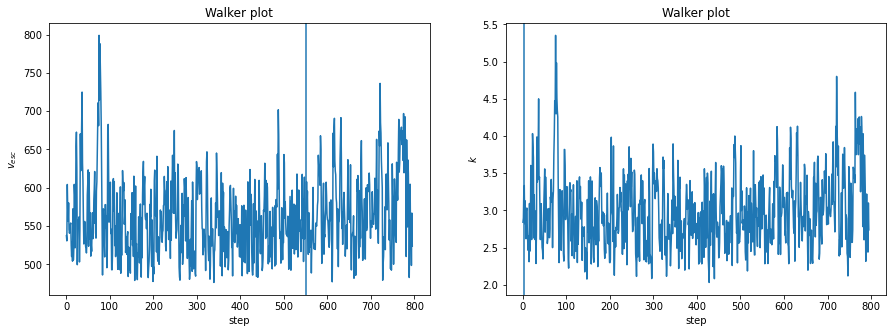

In [58]:
fig,axs=plt.subplots(ncols=2,figsize=(15,5))
axs[0].plot(accepted[burnin:,0])
axs[0].set_xlabel(r"step")
axs[0].set_ylabel(r"$v_{esc}$")
axs[0].set_title("Walker plot")
axs[0].axvline(x=target_vesc)

axs[1].plot(accepted[burnin:,1])
axs[1].set_xlabel(r"step")
axs[1].set_ylabel(r'$k$')
axs[1].set_title("Walker plot")
axs[1].axvline(x=target_k)

In [59]:
# Check acceptance fraction
len(accepted)/len(rejected)

0.08660219493643377

# Examine results closely

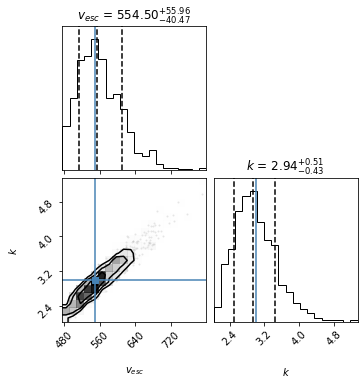

In [60]:
fig = corner.corner(
    accepted, labels=[r"$v_{esc}$",r'$k$'], truths=[target_vesc, target_k], quantiles=quantile_list,
                       show_titles=True, title_kwargs={"fontsize": 12}
)

### Result obtained in 6 minutes for 1000 data points and 50000 steps
That is, roughly 14 iterations per second